In [8]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-21 18:50:11.761989
thunder  Sat Dec 21 18:50:12 2019
[0] GeForce GTX 1080 Ti | 41'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 47'C,   0 % | 10895 / 11178 MB | patra(10885M)
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |   213 / 11178 MB | srikanth(203M)
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sat Dec 21 18:50:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   41C    P0    60W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 35%   48C    P2    73W / 250W |  10895Mi

In [9]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K


In [10]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [11]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [12]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [13]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [14]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [15]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [16]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [17]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [18]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [19]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [20]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [21]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [22]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

Normalizing using ImageDataGenerator https://stackoverflow.com/questions/41855512/how-does-data-normalization-work-in-keras-during-prediction

In [23]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True,
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./127.5-1) 
val_datagen = ImageDataGenerator(samplewise_center=True,
                                 featurewise_center=True, featurewise_std_normalization=True,
                                 rescale=1./127.5-1)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [24]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [25]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [26]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 25s 498ms/step - loss: 0.7662 - Accuracy: 0.5625 - Precision: 0.5503 - Recall: 0.6833 - F1: 0.5913 - AUC: 0.5955 - val_loss: 2.8006 - val_Accuracy: 0.0281 - val_Precision: 0.0281 - val_Recall: 0.7000 - val_F1: 0.0538 - val_AUC: 0.4525
Epoch 2/200
50/50 [==============================] - 23s 454ms/step - loss: 0.6591 - Accuracy: 0.6306 - Precision: 0.6332 - Recall: 0.6352 - F1: 0.6248 - AUC: 0.6779 - val_loss: 1.4709 - val_Accuracy: 0.0375 - val_Precision: 0.0283 - val_Recall: 0.6000 - val_F1: 0.0535 - val_AUC: 0.3919
Epoch 3/200
50/50 [==============================] - 24s 483ms/step - loss: 0.6556 - Accuracy: 0.6363 - Precision: 0.6371 - Recall: 0.6480 - F1: 0.6349 - AUC: 0.6770 - val_loss: 1.3264 - val_Accuracy: 0.0531 - val_Precision: 0.0379 - val_Recall: 0.6000 - val_F1: 0.0700 - val_AUC: 0.3489
Epoch 4/200
50/50 [==============================] - 23s 465ms/step - loss: 0.6416 - Accuracy: 0.6406 - Precision: 0.6393 - Recall: 0.6312 - F1: 0.6

50/50 [==============================] - 23s 469ms/step - loss: 0.5195 - Accuracy: 0.7450 - Precision: 0.7334 - Recall: 0.7758 - F1: 0.7461 - AUC: 0.8224 - val_loss: 1.6735 - val_Accuracy: 0.0375 - val_Precision: 0.0314 - val_Recall: 0.7000 - val_F1: 0.0594 - val_AUC: 0.6792
Epoch 30/200
50/50 [==============================] - 23s 461ms/step - loss: 0.5221 - Accuracy: 0.7362 - Precision: 0.7383 - Recall: 0.7668 - F1: 0.7401 - AUC: 0.8183 - val_loss: 1.8004 - val_Accuracy: 0.0312 - val_Precision: 0.0252 - val_Recall: 0.6000 - val_F1: 0.0482 - val_AUC: 0.5573
Epoch 31/200
50/50 [==============================] - 23s 463ms/step - loss: 0.5057 - Accuracy: 0.7550 - Precision: 0.7287 - Recall: 0.7907 - F1: 0.7503 - AUC: 0.8362 - val_loss: 1.3872 - val_Accuracy: 0.0469 - val_Precision: 0.0129 - val_Recall: 0.3000 - val_F1: 0.0247 - val_AUC: 0.5427
Epoch 32/200
50/50 [==============================] - 23s 470ms/step - loss: 0.5065 - Accuracy: 0.7581 - Precision: 0.7610 - Recall: 0.7739 - F1: 

50/50 [==============================] - 24s 477ms/step - loss: 0.5307 - Accuracy: 0.7456 - Precision: 0.7218 - Recall: 0.7811 - F1: 0.7447 - AUC: 0.8134 - val_loss: 1.3365 - val_Accuracy: 0.0469 - val_Precision: 0.0220 - val_Recall: 0.4000 - val_F1: 0.0412 - val_AUC: 0.4726
Epoch 58/200
50/50 [==============================] - 23s 457ms/step - loss: 0.5326 - Accuracy: 0.7287 - Precision: 0.7094 - Recall: 0.7634 - F1: 0.7283 - AUC: 0.8079 - val_loss: 1.4352 - val_Accuracy: 0.0500 - val_Precision: 0.0255 - val_Recall: 0.7000 - val_F1: 0.0491 - val_AUC: 0.4357
Epoch 59/200
50/50 [==============================] - 23s 463ms/step - loss: 0.5070 - Accuracy: 0.7631 - Precision: 0.7536 - Recall: 0.7859 - F1: 0.7625 - AUC: 0.8338 - val_loss: 1.4292 - val_Accuracy: 0.0406 - val_Precision: 0.0164 - val_Recall: 0.3000 - val_F1: 0.0305 - val_AUC: 0.4911
Epoch 60/200
50/50 [==============================] - 24s 475ms/step - loss: 0.5068 - Accuracy: 0.7531 - Precision: 0.7432 - Recall: 0.7756 - F1: 

50/50 [==============================] - 23s 456ms/step - loss: 0.5148 - Accuracy: 0.7431 - Precision: 0.7253 - Recall: 0.7842 - F1: 0.7463 - AUC: 0.8255 - val_loss: 1.2465 - val_Accuracy: 0.0656 - val_Precision: 0.0417 - val_Recall: 0.7000 - val_F1: 0.0773 - val_AUC: 0.5232
Epoch 86/200
50/50 [==============================] - 23s 464ms/step - loss: 0.5258 - Accuracy: 0.7225 - Precision: 0.7101 - Recall: 0.7528 - F1: 0.7260 - AUC: 0.8139 - val_loss: 1.3890 - val_Accuracy: 0.0500 - val_Precision: 0.0320 - val_Recall: 0.5167 - val_F1: 0.0596 - val_AUC: 0.4923
Epoch 87/200
50/50 [==============================] - 23s 450ms/step - loss: 0.5045 - Accuracy: 0.7556 - Precision: 0.7382 - Recall: 0.7777 - F1: 0.7497 - AUC: 0.8373 - val_loss: 1.3407 - val_Accuracy: 0.0562 - val_Precision: 0.0319 - val_Recall: 0.5000 - val_F1: 0.0589 - val_AUC: 0.6324
Epoch 88/200
50/50 [==============================] - 23s 453ms/step - loss: 0.4990 - Accuracy: 0.7606 - Precision: 0.7513 - Recall: 0.7814 - F1: 

50/50 [==============================] - 23s 452ms/step - loss: 0.5079 - Accuracy: 0.7462 - Precision: 0.7206 - Recall: 0.7851 - F1: 0.7415 - AUC: 0.8335 - val_loss: 1.4176 - val_Accuracy: 0.0500 - val_Precision: 0.0285 - val_Recall: 0.5000 - val_F1: 0.0535 - val_AUC: 0.6456
Epoch 114/200
50/50 [==============================] - 23s 452ms/step - loss: 0.5193 - Accuracy: 0.7344 - Precision: 0.7052 - Recall: 0.7614 - F1: 0.7246 - AUC: 0.8225 - val_loss: 1.4149 - val_Accuracy: 0.0656 - val_Precision: 0.0288 - val_Recall: 0.6000 - val_F1: 0.0545 - val_AUC: 0.5468
Epoch 115/200
50/50 [==============================] - 23s 459ms/step - loss: 0.5244 - Accuracy: 0.7390 - Precision: 0.7235 - Recall: 0.7695 - F1: 0.7380 - AUC: 0.8166 - val_loss: 1.3571 - val_Accuracy: 0.0406 - val_Precision: 0.0130 - val_Recall: 0.4000 - val_F1: 0.0252 - val_AUC: 0.6685
Epoch 116/200
50/50 [==============================] - 23s 453ms/step - loss: 0.5202 - Accuracy: 0.7362 - Precision: 0.7127 - Recall: 0.7658 - F

50/50 [==============================] - 24s 476ms/step - loss: 0.5190 - Accuracy: 0.7394 - Precision: 0.7313 - Recall: 0.7753 - F1: 0.7455 - AUC: 0.8220 - val_loss: 1.2978 - val_Accuracy: 0.0406 - val_Precision: 0.0128 - val_Recall: 0.4000 - val_F1: 0.0248 - val_AUC: 0.5763
Epoch 142/200
50/50 [==============================] - 23s 454ms/step - loss: 0.5029 - Accuracy: 0.7681 - Precision: 0.7486 - Recall: 0.7980 - F1: 0.7670 - AUC: 0.8402 - val_loss: 1.3956 - val_Accuracy: 0.0562 - val_Precision: 0.0131 - val_Recall: 0.2000 - val_F1: 0.0246 - val_AUC: 0.5688
Epoch 143/200
50/50 [==============================] - 23s 462ms/step - loss: 0.4967 - Accuracy: 0.7719 - Precision: 0.7628 - Recall: 0.7962 - F1: 0.7674 - AUC: 0.8452 - val_loss: 1.4207 - val_Accuracy: 0.0656 - val_Precision: 0.0260 - val_Recall: 0.6000 - val_F1: 0.0497 - val_AUC: 0.3754
Epoch 144/200
50/50 [==============================] - 23s 456ms/step - loss: 0.5136 - Accuracy: 0.7619 - Precision: 0.7406 - Recall: 0.7987 - F

50/50 [==============================] - 23s 462ms/step - loss: 0.4984 - Accuracy: 0.7688 - Precision: 0.7649 - Recall: 0.7907 - F1: 0.7688 - AUC: 0.8424 - val_loss: 1.4499 - val_Accuracy: 0.0469 - val_Precision: 0.0096 - val_Recall: 0.3000 - val_F1: 0.0186 - val_AUC: 0.6193
Epoch 170/200
50/50 [==============================] - 23s 462ms/step - loss: 0.4958 - Accuracy: 0.7688 - Precision: 0.7715 - Recall: 0.7843 - F1: 0.7711 - AUC: 0.8475 - val_loss: 1.2930 - val_Accuracy: 0.0625 - val_Precision: 0.0256 - val_Recall: 0.7000 - val_F1: 0.0493 - val_AUC: 0.6731
Epoch 171/200
50/50 [==============================] - 23s 460ms/step - loss: 0.4830 - Accuracy: 0.7694 - Precision: 0.7702 - Recall: 0.7954 - F1: 0.7764 - AUC: 0.8517 - val_loss: 1.3675 - val_Accuracy: 0.0531 - val_Precision: 0.0227 - val_Recall: 0.6000 - val_F1: 0.0436 - val_AUC: 0.5685
Epoch 172/200
50/50 [==============================] - 23s 462ms/step - loss: 0.5012 - Accuracy: 0.7581 - Precision: 0.7305 - Recall: 0.7988 - F

50/50 [==============================] - 22s 446ms/step - loss: 0.5028 - Accuracy: 0.7575 - Precision: 0.7264 - Recall: 0.8007 - F1: 0.7558 - AUC: 0.8399 - val_loss: 1.3862 - val_Accuracy: 0.0719 - val_Precision: 0.0325 - val_Recall: 0.8000 - val_F1: 0.0622 - val_AUC: 0.5983
Epoch 198/200
50/50 [==============================] - 23s 455ms/step - loss: 0.4975 - Accuracy: 0.7588 - Precision: 0.7260 - Recall: 0.7973 - F1: 0.7546 - AUC: 0.8416 - val_loss: 1.3869 - val_Accuracy: 0.0375 - val_Precision: 0.0128 - val_Recall: 0.4000 - val_F1: 0.0248 - val_AUC: 0.4312
Epoch 199/200
50/50 [==============================] - 23s 458ms/step - loss: 0.4862 - Accuracy: 0.7731 - Precision: 0.7578 - Recall: 0.8084 - F1: 0.7758 - AUC: 0.8544 - val_loss: 1.2994 - val_Accuracy: 0.0875 - val_Precision: 0.0368 - val_Recall: 0.7000 - val_F1: 0.0692 - val_AUC: 0.4857
Epoch 200/200
50/50 [==============================] - 23s 456ms/step - loss: 0.4844 - Accuracy: 0.7725 - Precision: 0.7671 - Recall: 0.8020 - F

In [27]:
print("Time taken:",end-start)

Time taken: 4623.303629159927


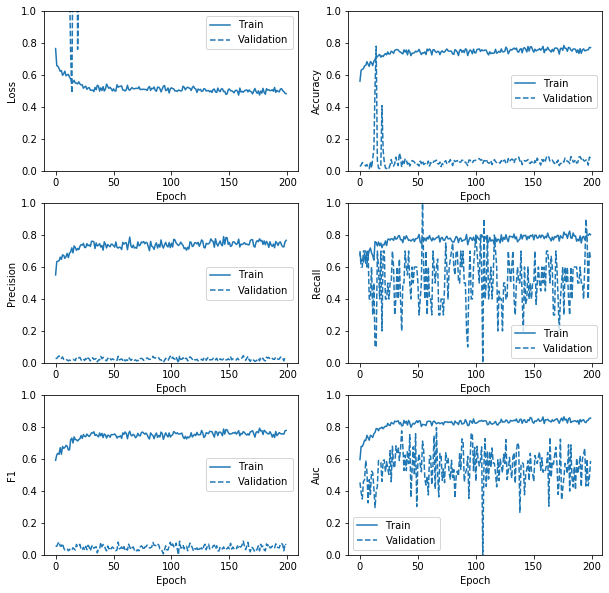

In [28]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [22]:
# start = time.time()
# up2_history = model.fit_generator(up2_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [1.5,0.5],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [23]:
# print("Time taken:",end-start)

In [24]:
# plt.figure(figsize=(10,10))
# plot_metrics(up2_history)

### Train with UP3 (1:20)

In [29]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = [0.5,3],
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 20s 395ms/step - loss: 0.7168 - Accuracy: 0.5806 - Precision: 0.0842 - Recall: 0.7600 - F1: 0.1483 - AUC: 0.8889 - val_loss: 1.3759 - val_Accuracy: 0.0500 - val_Precision: 0.0031 - val_Recall: 0.1000 - val_F1: 0.0061 - val_AUC: 0.2555
Epoch 2/200
50/50 [==============================] - 20s 399ms/step - loss: 0.6625 - Accuracy: 0.6169 - Precision: 0.1092 - Recall: 0.6867 - F1: 0.1824 - AUC: 0.8395 - val_loss: 1.2732 - val_Accuracy: 0.0625 - val_Precision: 0.0419 - val_Recall: 0.8000 - val_F1: 0.0788 - val_AUC: 0.5926
Epoch 3/200
50/50 [==============================] - 20s 397ms/step - loss: 0.6205 - Accuracy: 0.6544 - Precision: 0.1208 - Recall: 0.7967 - F1: 0.2047 - AUC: 0.8546 - val_loss: 1.2914 - val_Accuracy: 0.0812 - val_Precision: 0.0228 - val_Recall: 0.4000 - val_F1: 0.0430 - val_AUC: 0.7246
Epoch 4/200
50/50 [==============================] - 19s 388ms/step - loss: 0.5942 - Accuracy: 0.6800 - Precision: 0.1158 - Recall: 0.77

50/50 [==============================] - 18s 350ms/step - loss: 0.2878 - Accuracy: 0.9200 - Precision: 0.2588 - Recall: 0.3283 - F1: 0.2627 - AUC: 0.8492 - val_loss: 0.7654 - val_Accuracy: 0.3969 - val_Precision: 0.0245 - val_Recall: 0.2167 - val_F1: 0.0433 - val_AUC: 0.5545
Epoch 30/200
50/50 [==============================] - 18s 351ms/step - loss: 0.2836 - Accuracy: 0.9275 - Precision: 0.2717 - Recall: 0.2967 - F1: 0.2628 - AUC: 0.8423 - val_loss: 0.8694 - val_Accuracy: 0.3750 - val_Precision: 0.0241 - val_Recall: 0.4000 - val_F1: 0.0452 - val_AUC: 0.5876
Epoch 31/200
50/50 [==============================] - 17s 336ms/step - loss: 0.2857 - Accuracy: 0.9219 - Precision: 0.2970 - Recall: 0.3057 - F1: 0.2669 - AUC: 0.8596 - val_loss: 0.7597 - val_Accuracy: 0.3906 - val_Precision: 0.0392 - val_Recall: 0.5000 - val_F1: 0.0721 - val_AUC: 0.7108
Epoch 32/200
50/50 [==============================] - 18s 356ms/step - loss: 0.2777 - Accuracy: 0.9337 - Precision: 0.2453 - Recall: 0.2697 - F1: 

50/50 [==============================] - 17s 349ms/step - loss: 0.1956 - Accuracy: 0.9550 - Precision: 0.1200 - Recall: 0.0540 - F1: 0.0733 - AUC: 0.8525 - val_loss: 0.6343 - val_Accuracy: 0.7594 - val_Precision: 0.0660 - val_Recall: 0.2667 - val_F1: 0.1030 - val_AUC: 0.6153
Epoch 58/200
50/50 [==============================] - 17s 342ms/step - loss: 0.1946 - Accuracy: 0.9544 - Precision: 0.1200 - Recall: 0.0647 - F1: 0.0814 - AUC: 0.8492 - val_loss: 0.5422 - val_Accuracy: 0.7844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.2277
Epoch 59/200
50/50 [==============================] - 17s 350ms/step - loss: 0.2008 - Accuracy: 0.9506 - Precision: 0.0500 - Recall: 0.0400 - F1: 0.0400 - AUC: 0.8285 - val_loss: 0.5553 - val_Accuracy: 0.7688 - val_Precision: 0.0183 - val_Recall: 0.2000 - val_F1: 0.0336 - val_AUC: 0.6962
Epoch 60/200
50/50 [==============================] - 18s 356ms/step - loss: 0.2018 - Accuracy: 0.9481 - Precision: 0.1600 - Recall: 0

50/50 [==============================] - 18s 357ms/step - loss: 0.1700 - Accuracy: 0.9538 - Precision: 0.0400 - Recall: 0.0150 - F1: 0.0213 - AUC: 0.8312 - val_loss: 0.3665 - val_Accuracy: 0.9438 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5886
Epoch 86/200
50/50 [==============================] - 17s 341ms/step - loss: 0.1641 - Accuracy: 0.9581 - Precision: 0.0800 - Recall: 0.0467 - F1: 0.0567 - AUC: 0.8233 - val_loss: 0.3805 - val_Accuracy: 0.9312 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4650
Epoch 87/200
50/50 [==============================] - 18s 359ms/step - loss: 0.1750 - Accuracy: 0.9481 - Precision: 0.0600 - Recall: 0.0150 - F1: 0.0240 - AUC: 0.8468 - val_loss: 0.4812 - val_Accuracy: 0.9438 - val_Precision: 0.1500 - val_Recall: 0.2000 - val_F1: 0.1667 - val_AUC: 0.6063
Epoch 88/200
50/50 [==============================] - 18s 360ms/step - loss: 0.1815 - Accuracy: 0.9475 - Precision: 0.0000

50/50 [==============================] - 17s 337ms/step - loss: 0.1552 - Accuracy: 0.9513 - Precision: 0.0200 - Recall: 0.0050 - F1: 0.0080 - AUC: 0.8805 - val_loss: 0.2974 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5961
Epoch 113/200
50/50 [==============================] - 17s 331ms/step - loss: 0.1810 - Accuracy: 0.9438 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8289 - val_loss: 0.3813 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5594
Epoch 114/200
50/50 [==============================] - 17s 342ms/step - loss: 0.1531 - Accuracy: 0.9550 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8489 - val_loss: 0.3492 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4390
Epoch 115/200
50/50 [==============================] - 18s 360ms/step - loss: 0.1591 - Accuracy: 0.9513 - Pr

Epoch 139/200
50/50 [==============================] - 19s 378ms/step - loss: 0.1495 - Accuracy: 0.9556 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8465 - val_loss: 0.2439 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4692
Epoch 140/200
50/50 [==============================] - 18s 364ms/step - loss: 0.1363 - Accuracy: 0.9644 - Precision: 0.0400 - Recall: 0.0167 - F1: 0.0233 - AUC: 0.8156 - val_loss: 0.3141 - val_Accuracy: 0.9688 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.6695
Epoch 141/200
50/50 [==============================] - 19s 378ms/step - loss: 0.1612 - Accuracy: 0.9506 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.8517 - val_loss: 0.2954 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5809
Epoch 142/200
50/50 [==============================] - 18s 369ms/step - loss: 0.1634 - Accurac

Epoch 166/200
50/50 [==============================] - 16s 319ms/step - loss: 0.1573 - Accuracy: 0.9463 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.8839 - val_loss: 0.2243 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6116
Epoch 167/200
50/50 [==============================] - 15s 304ms/step - loss: 0.1485 - Accuracy: 0.9544 - Precision: 0.0400 - Recall: 0.0107 - F1: 0.0167 - AUC: 0.8742 - val_loss: 0.2397 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6733
Epoch 168/200
50/50 [==============================] - 19s 372ms/step - loss: 0.1477 - Accuracy: 0.9556 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8489 - val_loss: 0.2524 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3705
Epoch 169/200
50/50 [==============================] - 15s 309ms/step - loss: 0.1545 - Accurac

50/50 [==============================] - 19s 383ms/step - loss: 0.1470 - Accuracy: 0.9538 - Precision: 0.0400 - Recall: 0.0167 - F1: 0.0233 - AUC: 0.8720 - val_loss: 0.3611 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5040
Epoch 193/200
50/50 [==============================] - 20s 391ms/step - loss: 0.1475 - Accuracy: 0.9569 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8367 - val_loss: 0.2251 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3506
Epoch 194/200
50/50 [==============================] - 18s 353ms/step - loss: 0.1664 - Accuracy: 0.9488 - Precision: 0.0200 - Recall: 0.0050 - F1: 0.0080 - AUC: 0.8311 - val_loss: 0.2544 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4988
Epoch 195/200
50/50 [==============================] - 14s 270ms/step - loss: 0.1638 - Accuracy: 0.9481 - Pr

In [30]:
print("Time taken:",end-start)

Time taken: 3478.4623618125916


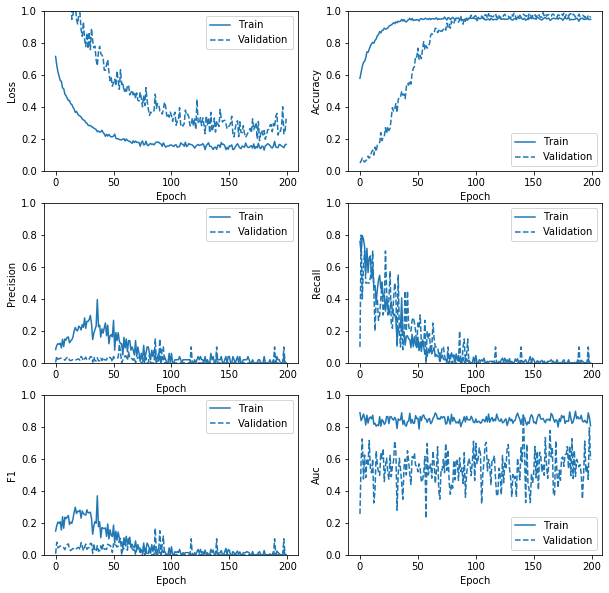

In [31]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [28]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [29]:
# print("Time taken:",end-start)

In [30]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [32]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = [0.2,5],
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [33]:
# print("Time taken:",end-start)

In [34]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [35]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 20s 197ms/step


In [36]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.230 :   0.270
Accuracy : 0.962 :   0.973
Precision : 0.000 :   0.000
Recall : 0.000 :   0.000
F1 : 0.000 :   0.000
AUC : 0.524 :   0.569


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [37]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1065.1883397102356, 187.73572826385498)

In [37]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [38]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [38]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

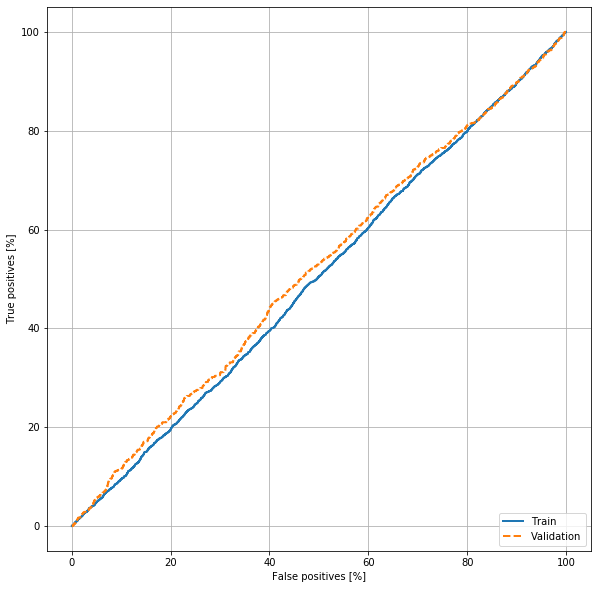

In [39]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 97983 
FP: 1472 
FN: 2344 
TP: 35
Healthy Patients - correctly identified (True Negatives):  97983 0.9851993363832889
Healthy Patients - predicted to have glaucoma (False Positives):  1472 0.014800663616711075
Glaucoma Patients - predicted healthy (False Negatives):  2344 0.9852879361076082
Glaucoma Patients - correctly identified (True Positives):  35 0.014712063892391762

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


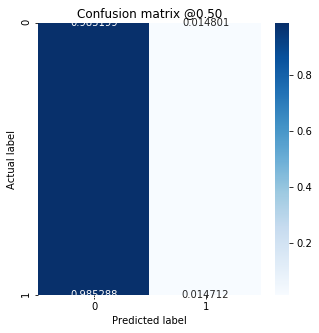

In [40]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33025 
FP: 109 
FN: 807 
TP: 2
Healthy Patients - correctly identified (True Negatives):  33025 0.9967103277600048
Healthy Patients - predicted to have glaucoma (False Positives):  109 0.0032896722399951713
Glaucoma Patients - predicted healthy (False Negatives):  807 0.9975278121137207
Glaucoma Patients - correctly identified (True Positives):  2 0.002472187886279357

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


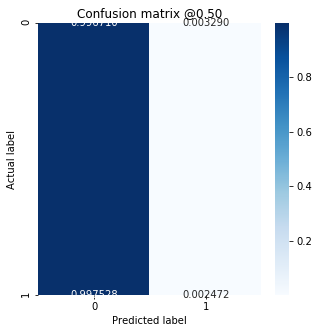

In [41]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [44]:
get_notebook_name()

<IPython.core.display.Javascript object>

'CNN Fundus- train_twice-Copy6.ipynb'

In [45]:
# history = up3_history
# tag_value = "same as copy 5 with feature wise centre = True"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

In [46]:
# client = MlflowClient()
# run = client.create_run('22')
# client.set_tag(run.info.run_id, "tag_key", tag_value)